In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt 
import os
import collections
import json
import matplotlib.image as mpimg
import tensorflow_text

In [2]:
batch_size = 128
root_dir = "datasets"
annotations_dir = os.path.join(root_dir, "annotations")
images_dir = os.path.join(root_dir, "train2014")
tfrecords_dir = os.path.join(root_dir, "tfrecords")
annotation_file = os.path.join(annotations_dir, "captions_train2014.json")

with open(annotation_file, "r") as f:
    annotations = json.load(f)["annotations"]

image_path_to_caption = collections.defaultdict(list)
for element in annotations:
    caption = f"{element['caption'].lower().rstrip('.')}"
    image_path = images_dir + "/COCO_train2014_" + "%012d.jpg" % (element["image_id"])
    image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
print(f"Number of images: {len(image_paths)}")

Number of images: 82783


In [3]:
print("Loading vision and text encoders...")
vision_encoder = keras.models.load_model("vision_encoder")
text_encoder = keras.models.load_model("text_encoder")
print("Models are loaded.")


def read_image(image_path):
    image_array = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    return tf.image.resize(image_array, (299, 299))


print(f"Generating embeddings for {len(image_paths)} images...")
image_embeddings = vision_encoder.predict(
    tf.data.Dataset.from_tensor_slices(image_paths).map(read_image).batch(batch_size),
    verbose=1,
)


print(f"Image embeddings shape: {image_embeddings.shape}.")

Loading vision and text encoders...
Models are loaded.
Generating embeddings for 82783 images...
647/647 [==============================] - 6147s 9s/step
Image embeddings shape: (82783, 256).


In [8]:

def find_matches(image_embeddings, queries, k=9, normalize=True):
    # Get the embedding for the query.
    query_embedding = text_encoder(tf.convert_to_tensor(queries))
    # Normalize the query and the image embeddings.
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        query_embedding = tf.math.l2_normalize(query_embedding, axis=1)
    # Compute the dot product between the query and the image embeddings.
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)
    # Retrieve top k indices.
    results = tf.math.top_k(dot_similarity, k).indices.numpy()
    # Return matching image paths.
    return [[image_paths[idx] for idx in indices] for indices in results]

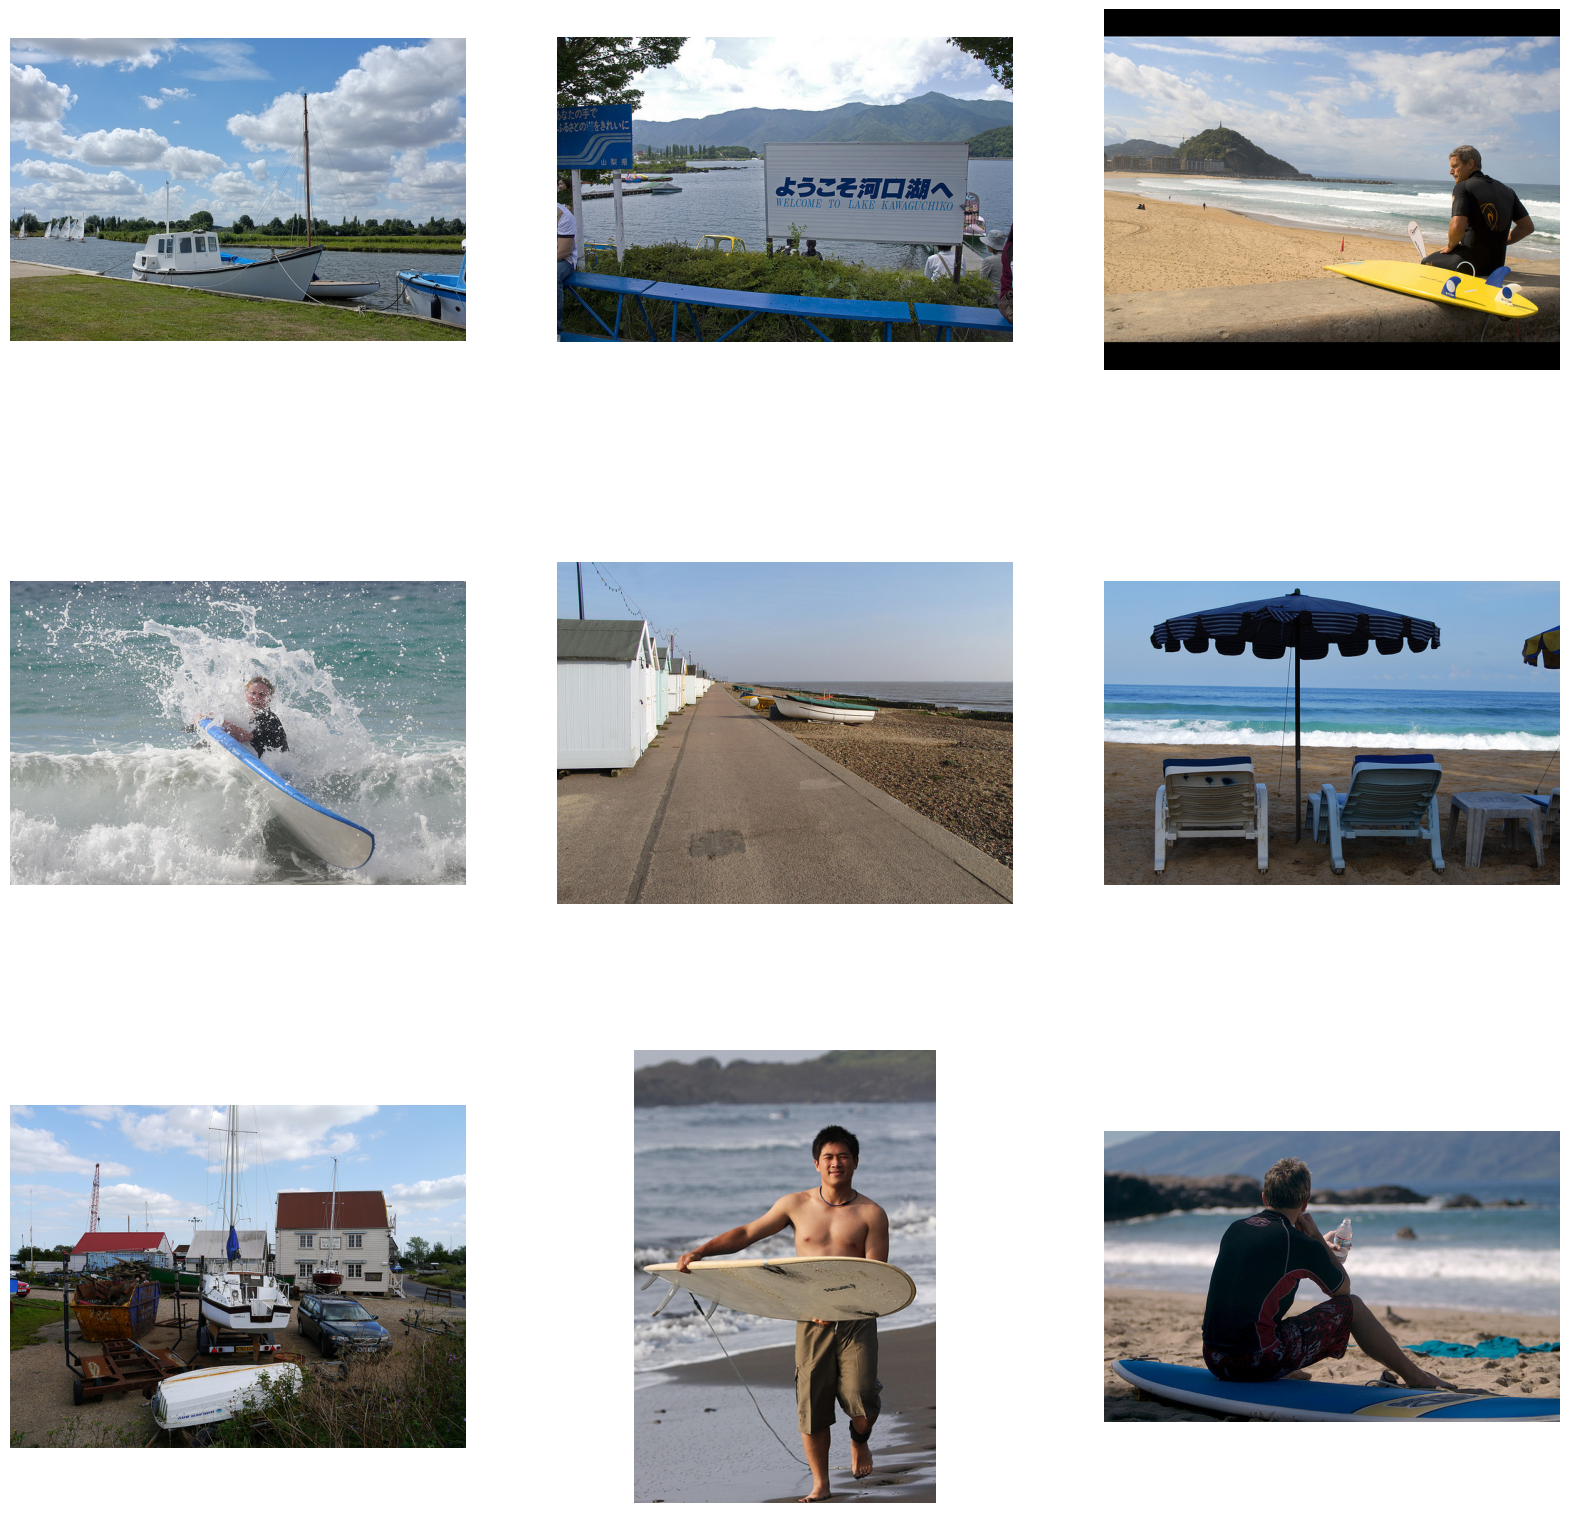

In [139]:

query = "man with surf board in beach"
matches = find_matches(image_embeddings, [query], normalize=True)[0]

plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(matches[i]))
    plt.axis("off")


In [84]:
matches

['datasets\\train2014/COCO_train2014_000000554987.jpg',
 'datasets\\train2014/COCO_train2014_000000127168.jpg',
 'datasets\\train2014/COCO_train2014_000000270406.jpg',
 'datasets\\train2014/COCO_train2014_000000469727.jpg',
 'datasets\\train2014/COCO_train2014_000000053121.jpg',
 'datasets\\train2014/COCO_train2014_000000294107.jpg',
 'datasets\\train2014/COCO_train2014_000000449850.jpg',
 'datasets\\train2014/COCO_train2014_000000521560.jpg',
 'datasets\\train2014/COCO_train2014_000000432770.jpg']